In [1]:
import numpy as np
import numpy.linalg as la
import scipy as sp
import scipy.integrate as spint
import matplotlib.pyplot as plt

from fluids.atmosphere import ATMOSPHERE_1976 as atm

import rocketPy as rp
from rocketPy import ureg, si, unit_vector, angle_between




Rocket: Simple Rocket

Rocket Details
+--------------------------+--------------+-------------------+
|        Parameter         |    Value     |       Notes       |
+--------------------------+--------------+-------------------+
|        Total Mass        |  1.9803 kg   |                   |
|       Total Length       |  70.0000 in  |                   |
|           X_CG           |  1.152304 m  |                   |
|           X_CP           |   1.1799 m   | At default values |
| Static Margin (calibers) |    0.1813    | At default values |
|            CD            |    0.2894    | At default values |
|           CNa            | 9.0907 / rad | At default values |
+--------------------------+--------------+-------------------+

Component Details
+-----------+------------+------------+---------+-----------------+--------------+
| Component |    Type    |  Material  |   Mass  | Mass Fraction % |     CNa      |
+-----------+------------+------------+---------+-----------------+------

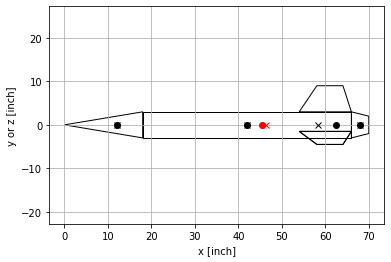

In [2]:
# generate rocket

## First, create a rocket.
r = rp.Rocket(name='Simple Rocket')

## create a nose cone
nc = rp.NoseCone(name='Nose Cone', diameter=6*ureg.inch, fineness=3, material=rp.materials.PLA())
# assign to rocket
r.set_nose_cone(nc)

## create a BodyTube
bt = rp.BodyTube(name = 'Body Tube', diameter=6*ureg.inch, length=48*ureg.inch, wall_thickness=2*ureg.mm, material=rp.materials.Phenolic())
# define its location
bt.set_position(after=nc)
# assign to rocket
r.set_body_tube(bt)

# create a boat tail
boat_tail = rp.Transition(name='Boat Tail', fore_dia=6*ureg.inch, aft_dia=4*ureg.inch, length=4*ureg.inch, material=rp.materials.Phenolic())
# define its location
boat_tail.set_position(after=bt)
# assign to rocket
r.set_boat_tail(boat_tail)

## create the fins
fins = rp.FinSet(name='Fins', n=3, span=6*ureg.inch, root_chord=12*ureg.inch, tip_chord=6*ureg.inch, mid_sweep=10*ureg.degree, tube_dia=6*ureg.inch,  thickness=2*ureg.mm, material=rp.materials.Aluminium())
# define its location
fins.set_position(end_of=bt, offset=-fins.root_chord)
#  assign to rocket
r.set_fins(fins)

# plot the entire rocket
fig = plt.figure()
ax = plt.gca()
r.plot(ax, unit=ureg.inch)
plt.draw()

# describe the rocket
r.describe(describe_components=False)

plt.show()



In [3]:
r.xcp()

1.1799275034283525 <Unit('meter')>

In [4]:
r.xcp()

1.1799275034283525 <Unit('meter')>

In [5]:
r.static_margin()

0.18125361774699797 <Unit('dimensionless')>

In [6]:
r.CD_body_alpha(alpha=(3*np.pi/180)*ureg.rad)

0.0030266791135803548 <Unit('dimensionless')>

In [7]:
r.CD_body_alpha(alpha=3*ureg.degree)

0.003026679113580355 <Unit('dimensionless')>

In [8]:
class Environment():
    
    def __init__(self):
        
        # define constants
        self.gamma = 1.4
        self.R = 287*ureg.J/ureg.kg/ureg.degK
        self.ref_temp = 291.15*ureg.degK
        self.ref_visc = 1.827e-7*ureg.Pa/ureg.s
        self.g_0_si = 9.80665
        self.g_0 = self.g_0_si*ureg.m/ureg.s**2
        self.rho_0 = 1.225*ureg.kg/ureg.m**3
         
            
           
    def _rho(self, z):
        
        return atm(z).rho
    
    def _mu(self, z):
        
        return atm(z).mu
    
    def _temp(self, z):
        
        return atm(z).T
    
    def _speed_of_sound(self, z):
        
        return atm(z).v_sonic
    
    
    @ureg.wraps(ureg.kg/ureg.m**3, (None, ureg.m), strict=False)
    def get_rho(self, z):
        
        return self._rho(z)
    
    @ureg.wraps(ureg.Pa*ureg.s, (None, ureg.m), strict=False)
    def get_mu(self, z):
        return self._mu(z)
        
    @ureg.wraps(ureg.degK, (None, ureg.m), strict=False)
    def get_temp(self, z):
        
        return self._temp(z)
    
    @ureg.wraps(ureg.m/ureg.s, (None, ureg.m), strict=False)
    def get_speed_of_sound(self, z):
        
        return self._speed_of_sound(z)
        

    
    
    def frozen_wind(t, state):
        
        # function to describe the wind vector (in earth frame) as a function of time or state
        return np.array([1,0,0])
    
    

In [9]:
class State():
    
    def __init__(self, pos, quaternion, lin_mom, ang_mom, mass):
        
        self.pos = pos
        self.quat = quaternion
        self.lin_mom = lin_mom
        self.ang_mom = ang_mom
        self.mass = mass
        
    def vector(self):
        
        state = [si(self.pos), si(self.quat), si(self.lin_mom), si(self.ang_mom), si(self.mass)] 

        return np.hstack(state)
    
    @classmethod
    def extract(cls, state):
        
        pos = state[0:3] * ureg.m
        quat = rp.Quaternion(*state[3:7])
        lin_mom = state[7:10] * ureg.kg*ureg.m/ureg.s
        ang_mom = state[10:13] * ureg.kg*ureg.m**2/ureg.s
        mass = state[13] * ureg.kg
        
        return cls(pos, quat, lin_mom, ang_mom, mass)
    
    @classmethod
    def split(cls, state_vector):
        
        pos = state_vector[0:3]
        quat = rp.Quaternion(*state_vector[3:7])
        lin_mom = state_vector[7:10]
        ang_mom = state_vector[10:13]
        mass = state_vector[13]
        
        return (pos, quat, lin_mom, ang_mom, mass)
    

    
    def __repr__(self):
    
        s  = 'State: \n'
        s += 'Pos:     ' + str(self.pos)  + '\n'
        s += 'Quat:    ' + str(self.quat) + '\n'
        s += 'Lin mom: ' + str(self.lin_mom) + '\n'
        s += 'Ang mom: ' + str(self.ang_mom) + '\n'
        s += 'Mass:    ' + str(self.mass)
        
        return s
    
        
        

In [10]:
class ConstantWind():

    def __init__(self, wind_speed = 5 * ureg.m/ureg.s):
        
        self.wind_speed_0 = wind_speed
        self.si_wind_speed = si(wind_speed)
        
    def vector(self, t=None, pos=None):
        
        return np.array([0, self.si_wind_speed, 0])
    
  

In [90]:
class Simulation():
    
    def __init__(self, rocket, environment):
        
        self.rocket = rocket
        self.env = environment
        
        self.ref_axis_R = np.array([1,0,0]) # roll axis
        self.ref_axis_P = np.array([0,1,0]) # pitch axis
        self.ref_axis_Y = np.array([0,0,1]) # yaw axis
        
        self.L_rocket = si(self.rocket.length())
        self.A_ref = si(self.rocket.A_ref)
            
            
        return

        
    
    def dynamics(self, time, state, control, wind):
        
        # everything here is assumed to be in si units
        
        L_rocket = self.L_rocket
        A_ref = self.A_ref
        
        # extract state
        if type(state) is State:
            pos = si(state.pos)
            quat = state.quat
            lin_mom = si(state.lin_mom)
            ang_mom = si(state.ang_mom)
            mass = si(state.mass)
        
        pos, quat, lin_mom, ang_mom, mass = State.split(state)
        
        # extract extra stuff
        R = quat.rot_matrix()
        RA = unit_vector(R @ self.ref_axis_R) # roll axis
        
        inertia_matrix, inv_inertia_matrix = self.rocket.inertia_matrix(mass, with_inverse=True) # get the inertia matrix for a given total rocket mass
        
        # linear velocity
        lin_vel = lin_mom / mass
        
        # angular velocity
        
        ang_vel = R @ inv_inertia_matrix @ R.T @ ang_mom
        
        # rate of change of quaterinon 
        qdot = self.get_qdot(quat, lin_vel, ang_vel)
        
        # get wind speed
        w = wind.vector(time, pos)
        
        # calculate angle of attack
        V_cm = lin_vel + w
        
        
        # calculate all these parameters, automatically performing convergence as necessary
        alpha, re, mach, xbar, V_omega, V_infty = self.calc_parameters_converged(V_cm, R, RA, pos, mass, ang_vel)
        
        #TODO (medium): calc fin roll torque
        
        z = pos[2]
        qinf, Re, Ma = self.calc_q_Re_Ma(V_infty, z)
        
        # compute forces
        F_thrust_mag, m_dot = control(time, state)
        F_thrust = -F_thrust_mag * RA
        
        F_gravity = np.array([0, 0, -mass*self.env.g_0_si])
        
        CA = si(self.rocket.CA(alpha=alpha, Re=Re, Mach=Ma))
        CN = si(self.rocket.CN(alpha=alpha, Re=Re, Mach=Ma))
        
        F_axial  = - (qinf * CA * A_ref)
        F_axial_vec = F_axial * RA
        F_normal = (qinf * CN * A_ref)
        F_normal_vec = F_normal * np.cross(RA, np.cross(RA, V_infty))
        
        F_total = F_thrust + F_gravity + F_axial_vec + F_normal_vec
        
        # get torques
        
        normal_moment_arm = si(self.rocket.xcp(alpha=alpha*ureg.rad, Re=Re, Mach=Ma) - self.rocket.xcg(mass=mass))
        
        torque_normal = - F_normal * normal_moment_arm * np.cross(RA, V_infty)
        
        # todo (medium): account for thrust damping, roll torque from fins
        
        torque_total = torque_normal
        
        
        return np.hstack([lin_vel, qdot, F_total, torque_total, m_dot])


    def concise_dynamics(self, time, state):
        
        #determine controls
        
        # convert vector into state object
        sv = State.extract(state)
        
        wind = self.env.wind
        
        dyn = self.dynamics(time=time, state=sv, control=self.control_law, wind=wind)
        
        return dyn

        
        
    
    def calc_parameters_converged(self, V_cm, R, RA, pos, mass, ang_vel):
        
        if la.norm(ang_vel) < 0.1:
            
            return self.calc_parameters(V_cm, V_cm, R, RA, pos, mass, ang_vel)

        else:
            #calculate using V_cm
            alpha_old, re, mach, xbar, V_omega, V_infty = self.calc_parameters(V_cm, V_cm, R, RA, pos, mass, ang_vel)

            # calculate new alpha
            alpha, re, mach, xbar, V_omega, V_infty = self.calc_parameters(V_infty, V_cm, R, RA, pos, mass, ang_vel)


            # if the difference is large, re-estimate
            while abs(alpha_old - alpha) > 1e-6:

                alpha_old = alpha
                alpha, re, mach, xbar, V_omega, V_infty = self.calc_parameters(V_infty, V_cm, R, RA, pos, mass, ang_vel)

        return alpha, re, mach, xbar, V_omega, V_infty 

    
    def calc_parameters(self, V_infty, V_cm, R, RA, pos, mass, ang_vel):
        # note, V_infty here is a guess, but the corrected value comes out of the function
            
        alpha = self.calc_alpha(V_infty, RA) #using V_cm as an approximation for V_infty
        
        z = pos[2]
        q, re, mach = self.calc_q_Re_Ma(la.norm(V_infty), z)

        xbar = abs((self.rocket.xcp(alpha, re, mach) - self.rocket.xcg(mass*ureg.kg)).m_as(ureg.m))
        
        V_omega = xbar * np.cross(RA, ang_vel)# linear speed at the center of pressure due to the rotation rate of the rocket

        V_infty = V_cm + V_omega

        return alpha, re, mach, xbar, V_omega, V_infty

    def calc_q_Re_Ma(self, Vinf, z):
        """Calculate reynolds number for a given vinf and altitude z"""
        
        rho = self.env._rho(z)
        mu  = self.env._mu(z)
        a = self.env._speed_of_sound(z)
        
        L_rocket = self.L_rocket
        
        V = (la.norm(Vinf))
        qinf = 0.5 * rho * V**2
        Re = rho*V*L_rocket/mu
        Ma = V/a
        
        return qinf, Re, Ma
    
    def calc_alpha(self, Vinf, RA):
        """Calc alpha for a given wind speed Vinf and roll axis RA"""
        
        return angle_between(Vinf, RA)

        
    def get_qdot(self, quat, lin_vel, ang_vel):
        """Compute the rate of change of the quaternion"""
        s = float(quat.q[0])
        sdot = 0.5 * ang_vel.T @ lin_vel
        vdot = 0.5 * s * ang_vel + np.cross(ang_vel, ang_vel)
        
        qdot =  np.hstack([sdot, vdot])
        return qdot

In [91]:
env=Environment()

# define wind model
wind_constant = ConstantWind(0*ureg.m/ureg.s)      
env.wind = wind_constant

In [92]:
pos0 = np.array([0,0,0])*ureg.m
quat0 = rp.Quaternion.from_angle(86*ureg.degree, [0, 1, 0])
lin_mom0 = np.array([0,0,0.1])*ureg.kg*ureg.m/ureg.s
ang_mom0 = np.array([0,0,0])*ureg.kg*ureg.m**2/ureg.s
mass0 = 40*ureg.kg

state0 = State(pos0, quat0, lin_mom0, ang_mom0, mass0)

In [93]:
state0

State: 
Pos:     [0 0 0] meter
Quat:    [0.7313537  0.         0.68199836 0.        ]
Lin mom: [0.0 0.0 0.1] kilogram * meter / second
Ang mom: [0.0 0.0 0.0] kilogram * meter ** 2 / second
Mass:    40 kilogram

In [94]:
[si(pos0), si(quat0)]

[array([0, 0, 0]), array([0.7313537 , 0.        , 0.68199836, 0.        ])]

In [95]:
sv_0=state0.vector()
sv_0

array([ 0.        ,  0.        ,  0.        ,  0.7313537 ,  0.        ,
        0.68199836,  0.        ,  0.        ,  0.        ,  0.1       ,
        0.        ,  0.        ,  0.        , 40.        ])

In [96]:
def thrust_curve_simple_burn(time, state):
    if time < 3:
        T = 1500
        c = 2000
        mdot = -T/c
        return T, mdot 
    else:
        return 0., 0

In [97]:
sim = Simulation(r, env)

In [98]:
sim.control_law = thrust_curve_simple_burn

In [99]:
state0

State: 
Pos:     [0 0 0] meter
Quat:    [0.7313537  0.         0.68199836 0.        ]
Lin mom: [0.0 0.0 0.1] kilogram * meter / second
Ang mom: [0.0 0.0 0.0] kilogram * meter ** 2 / second
Mass:    40 kilogram

In [100]:
state0.quat.rot_matrix()

array([[ 0.06975647,  0.        ,  0.99756405],
       [ 0.        ,  1.        ,  0.        ],
       [-0.99756405,  0.        ,  0.06975647]])

In [101]:
dyn=sim.dynamics(time=0,state=state0.vector(), control=thrust_curve_simple_burn, wind=wind_constant)
dyn

array([ 0.00000000e+00,  0.00000000e+00,  2.50000000e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.04634707e+02,
        0.00000000e+00,  1.10408002e+03,  0.00000000e+00, -1.01125010e-10,
        0.00000000e+00, -7.50000000e-01])

In [102]:
State.extract(dyn)

State: 
Pos:     [0.0 0.0 0.0025] meter
Quat:    [0. 0. 0. 0.]
Lin mom: [-104.63470665355477 0.0 1104.0800186983317] kilogram * meter / second
Ang mom: [0.0 -1.0112500967214171e-10 0.0] kilogram * meter ** 2 / second
Mass:    -0.75 kilogram

In [103]:
wind_constant.wind_speed_0

0.0 <Unit('meter / second')>

In [104]:
sim.dynamics(0, state0.vector(), thrust_curve_simple_burn, wind_constant)

array([ 0.00000000e+00,  0.00000000e+00,  2.50000000e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.04634707e+02,
        0.00000000e+00,  1.10408002e+03,  0.00000000e+00, -1.01125010e-10,
        0.00000000e+00, -7.50000000e-01])

In [105]:
len(sv_0)

14

In [106]:
sim.dynamics(0, sv_0, thrust_curve_simple_burn, wind_constant)

array([ 0.00000000e+00,  0.00000000e+00,  2.50000000e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.04634707e+02,
        0.00000000e+00,  1.10408002e+03,  0.00000000e+00, -1.01125010e-10,
        0.00000000e+00, -7.50000000e-01])

In [107]:
len(sim.dynamics(0, sv_0, thrust_curve_simple_burn, wind_constant))

14

In [108]:
state0.vector()

array([ 0.        ,  0.        ,  0.        ,  0.7313537 ,  0.        ,
        0.68199836,  0.        ,  0.        ,  0.        ,  0.1       ,
        0.        ,  0.        ,  0.        , 40.        ])

In [109]:
wind_constant

In [ ]:
sol = spint.solve_ivp(sim.dynamics, [0,5], state0.vector(), args = (thrust_curve_simple_burn, wind_constant))

In [ ]:
sol

In [ ]:
pos_sol = sol.y[0:3][:]

In [ ]:
pos_sol

In [ ]:
plt.plot(pos_sol[0][:], pos_sol[2][:])
ax=plt.gca()
ax.set_aspect(1)

In [ ]:
plt.plot(sol.t, pos_sol.T)

In [ ]:

(r.xcp(Mach=0) - r.xcg())

In [ ]:
r.CA(alpha=0*ureg.rad, Re=1000000.0, Mach=0.3)

In [ ]:
R @ la.inv(im)

In [ ]:
float(state0.quat.q[0])

In [ ]:
r.inertia_matrix()

In [ ]:
import scipy.integrate as spint

In [ ]:
state = np.array([0, 3])

In [ ]:
x, y = state

In [ ]:
def dynamics(state, control, time):
    # extract
    x, xd = state
    u = control
    
    # compute dynamics
    xdd = u
    
    return np.array([xd, xdd])

In [ ]:
def control(state, time):
    
    x, xd = state
    u = -0.1*(x-5) -0.1*xd
        
    return u

In [ ]:
def concise_dynamics(time, state):
    
    u = control(state, time)
    
    dyn = dynamics(state, u, time)
    
    return dyn
    

In [ ]:
concise_dynamics(0, np.array([5,6]))

In [ ]:
state0 = np.array([0, 0])

In [ ]:
sol1=spint.solve_ivp(concise_dynamics, (0, 100), state0, max_step=0.1)
sol2=spint.solve_ivp(concise_dynamics, (0, 100), state0, max_step=1)
sol3=spint.solve_ivp(concise_dynamics, (0, 100), state0)

In [ ]:
sol

In [ ]:
plt.plot(sol.t, sol.y[1,:])

In [ ]:
plt.plot(sol.t, sol.y[0,:],'x')

In [ ]:
plt.plot(np.diff(sol.t))

In [ ]:
plt.plot(sol1.t, sol1.y[0])
plt.plot(sol2.t, sol2.y[0])
plt.plot(sol3.t, sol3.y[0])

In [ ]:
plt.plot(np.diff(sol1.t))
plt.plot(np.diff(sol2.t))
plt.plot(np.diff(sol3.t))